# Impacto de la deforestación en el regimen de caudales de los rios en Colombia (TEAM 28)

## Multivariate time series forecasting

Sources :

https://towardsdatascience.com/vector-autoregressions-vector-error-correction-multivariate-model-a69daf6ab618

https://towardsdatascience.com/pairs-trading-with-cryptocurrencies-e79b4a00b015

### Libraries

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.tsa.vector_ar as var
import sklearn.metrics as skm

from statsmodels.tsa.stattools import grangercausalitytests # Granger's Causality Test

from statsmodels.graphics.tsaplots import plot_acf # Autocorrelation plot
from statsmodels.graphics.tsaplots import plot_pacf # PartialAutocorrelation plot

from sklearn.model_selection import train_test_split # Split data for machine learning

from statsmodels.tsa.stattools import adfuller # Augmented Dickey-Fuller Test (ADF Test)/unit root test
from statsmodels.tsa.stattools import coint  # Johansen Test for Cointegration (Just two data series)

from coint_johansen import coint_johansen  # Johansen Test for Cointegration more two data series
from scipy.stats import zscore # Calculates the z score of each value in the sample, relative to the sample mean and standard deviation.

from sklearn.utils import check_array # Para calculo de MAPE

from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num = None, figsize = (15, 12), dpi = 80, facecolor = 'w', edgecolor = 'k')
plt.rcParams.update({'font.size': 16, 'figure.figsize': (15, 10), 
                     'figure.max_open_warning': 20000})

# machine learning: XGB
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from xgboost.sklearn import XGBRegressor # wrapper

<Figure size 1200x960 with 0 Axes>

In [2]:
print(plt.rcParams.keys())

KeysView(RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.avconv_args': [],
          'animation.avconv_path': 'avconv',
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.html_args': [],
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
        

-----------------------------

### Read Data

In [3]:
macrodata = pd.read_csv('../data/matrix/matrix_consol_v2.zip')

macrodata.head(10)

date  year  month  mc  v_flow_mean  v_loss_cover  v_rainfall_total  \
0  2000-01  2000      1   7        230.4      0.000000             334.0   
1  2000-02  2000      2   7        272.4      0.000133             400.0   
2  2000-03  2000      3   7        321.6      0.000265             319.0   
3  2000-04  2000      4   7        310.8      0.000398             248.0   
4  2000-05  2000      5   7        410.0      0.000531             302.0   
5  2000-06  2000      6   7        295.9      0.000663              81.0   
6  2000-07  2000      7   7        244.2      0.000796              96.0   
7  2000-08  2000      8   7        255.0      0.000928              64.0   
8  2000-09  2000      9   7        233.8      0.001061             262.0   
9  2000-10  2000     10   7        216.0      0.001194             141.0   

   v_temperature_mean  
0                 NaN  
1                 NaN  
2                 NaN  
3                 NaN  
4                 NaN  
5                 NaN  
6                 NaN  
7                 NaN  
8                 NaN  
9                 NaN

In [4]:
mcs = macrodata['mc'].unique()
mcs.sort()

print(mcs)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48]


### Check if the data is random

A quick test is to check if the data is random. Random data will not exhibit a structure in the lag plot.

In [ ]:
for i in mcs:
    temp_df = macrodata[macrodata['mc'] == i].copy()
    temp_df = temp_df[['v_flow_mean', 'v_loss_cover', 
                       'v_rainfall_total', 'v_temperature_mean']]

    main_title = 'Macro basin ' + str(i)
    
    temp_df = temp_df.apply(zscore)

    fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, ncols = 1, figsize = (15,10))
    temp_df.plot(ax = ax1, title = main_title)
    pd.plotting.lag_plot(temp_df, ax = ax2, lag = 1)
    pd.plotting.lag_plot(temp_df, ax = ax3, lag = 2)
    plt.show()

The random structure should look like the following graph.

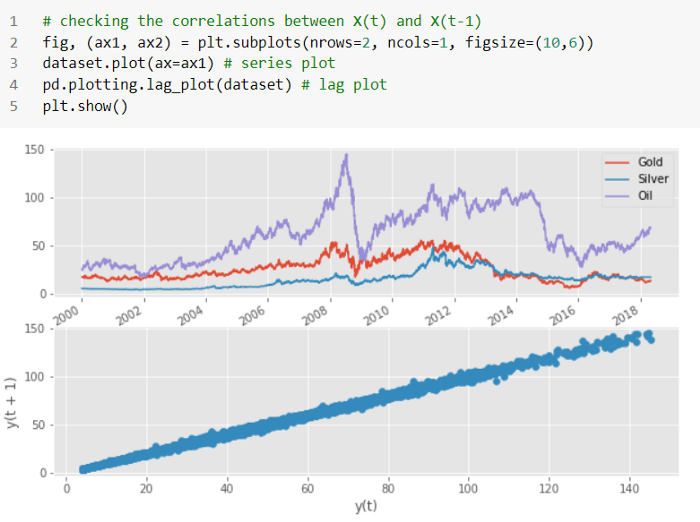

### Seasonal-Trend decomposition

#### Variable v_flow_mean

In [ ]:
attr = ['observed', 'trend', 'seasonal', 'resid']

for i in mcs:
    temp_df = macrodata.v_flow_mean[macrodata['mc'] == i].copy()
    main_title = 'Macro basin ' + str(i) + ' Variable v_flow_mean'
    fig, ax = plt.subplots(len(attr), 1, sharex=True)
    sd = sm.tsa.seasonal_decompose(temp_df, model = 'additive', period = 12)
    
    for idx, a in enumerate(attr):
        s_attr = getattr(sd, a)
        s_attr.plot(ax = ax[idx], title = main_title if idx == 0 else None)
        ax[idx].set(ylabel = a)

#### Variable v_loss_cover

In [ ]:
attr = ['observed', 'trend', 'seasonal', 'resid']

for i in mcs:
    temp_df = macrodata.v_loss_cover[macrodata['mc'] == i].copy()
    main_title = 'Macro basin ' + str(i) + ' Variable v_loss_cover'
    fig, ax = plt.subplots(len(attr), 1, sharex=True)
    sd = sm.tsa.seasonal_decompose(temp_df, model = 'additive', period = 12)
    
    for idx, a in enumerate(attr):
        s_attr = getattr(sd, a)
        s_attr.plot(ax = ax[idx], title = main_title if idx == 0 else None)
        ax[idx].set(ylabel = a)

#### Variable v_rainfall_total

In [ ]:
attr = ['observed', 'trend', 'seasonal', 'resid']

for i in mcs:
    temp_df = macrodata.v_rainfall_total[macrodata['mc'] == i].copy()
    main_title = 'Macro basin ' + str(i) + ' Variable v_rainfall_total'
    fig, ax = plt.subplots(len(attr), 1, sharex=True)
    sd = sm.tsa.seasonal_decompose(temp_df, model = 'additive', period = 12)
    
    for idx, a in enumerate(attr):
        s_attr = getattr(sd, a)
        s_attr.plot(ax = ax[idx], title = main_title if idx == 0 else None)
        ax[idx].set(ylabel = a)

#### Variable v_temperature_mean (prevents macro-basins with null values)

In [ ]:
attr = ['observed', 'trend', 'seasonal', 'resid']

for i in mcs:
    temp_df = macrodata.v_temperature_mean[macrodata['mc'] == i].copy()
    if (temp_df.isnull().sum() == 0):
        temp_df = temp_df.fillna(temp_df)
        main_title = 'Macro basin ' + str(i) + ' Variable v_temperature_mean'
        fig, ax = plt.subplots(len(attr), 1, sharex=True)
        sd = sm.tsa.seasonal_decompose(temp_df, model = 'additive', period = 12)

        for idx, a in enumerate(attr):
            s_attr = getattr(sd, a)
            s_attr.plot(ax = ax[idx], title = main_title if idx == 0 else None)
            ax[idx].set(ylabel = a)

### Autocorrelation plots

In [ ]:
for i in mcs:
    temp_df = macrodata[macrodata['mc'] == i].copy()
    temp_df = temp_df[['v_flow_mean', 'v_loss_cover', 
                       'v_rainfall_total', 'v_temperature_mean']]
    
    for j in temp_df:
        fig, ax1 = plt.subplots(nrows = 1, ncols = 1, figsize = (15,3))
        plot_acf(temp_df[j], lags = 50, ax = ax1)
        plt.title('MC = %s - ACF for %s' % (i, j))
        plt.show()

### Granger's Causality Test

Causalidad de Wiener-Granger o Test de Wiener-Granger: Desarrollado por el Premio en Ciencias Económicas en memoria de Alfred Nobel (año 2003) Clive W. J. Granger (1934-2009), a partir de las indicaciones de Norbert Wiener. Es un test consistente en comprobar si los resultados de una variable sirven para predecir a otra variable, si tiene carácter unidireccional o bidireccional. Para ello se tiene que comparar y deducir si el comportamiento actual y el pasado de una serie temporal A predice la conducta de una serie temporal B. Si ocurre el hecho, se dice que “el resultado A” causa en el sentido de Wiener-Granger “el resultado B”; el comportamiento es unidireccional. Si sucede lo explicado e igualmente “el resultado B” predice “el resultado A”, el comportamiento es bidireccional, entonces “el resultado A” causa “el resultado B”, y “el resultado B” causa “el resultado A”. 

https://www.analyticslane.com/2019/11/18/test-de-causalidad-de-wiener-granger/

$H_0 $ : NO existe una relación entre las variables.

$H_a $ : SI existe una relación entre las variables.

Si p-value < $\alpha$ (0.05) se rechaza $H_0 $; lo que implica que SI hay relación entre las variables.

In [ ]:
def likelihood_Granger(mbasin, granger_result, max_lags):
    
    mBasin_Granger = []

    lk_p_val = 12
    pval = 100
    foundit = False
    
    for i in range(1,max_lags):
        pval = 100
        
        for x in list((list(granger_result[mbasin][i])))[0:1]:
            lk_lag = x.get('lrtest', None)
            p_val = lk_lag[1]
            
            if (p_val < 0.05):
                mBasin_Granger.append(i)
                mBasin_Granger.append(p_val)
                foundit = True
#                 print(x)
#                 print(lk_lag, p_val)
                break
                
        if (foundit == True):
            break
            
    return(mBasin_Granger)

#### v_flow_mean vs v_loss_cover

In [ ]:
mc_stat_fl_lc = []
mc_stat_fl_lc_nnull = []

for i in mcs:
    temp_df = macrodata[macrodata['mc'] == i][['v_flow_mean', 'v_loss_cover']].copy().reset_index(drop = True)
    
    print('MC = ', i)
    print('-------')
    granger_test = sm.tsa.stattools.grangercausalitytests(temp_df, maxlag = 12, 
                                                          verbose = True)
    granger_test
    mc_stat_fl_lc_nnull.append(i)
    mc_stat_fl_lc.append(granger_test)    
    print('\n')

#### v_flow_mean vs v_rainfall_total

In [ ]:
mc_stat_fl_rf = []
mc_stat_fl_rf_nnull = []

for i in mcs:
    temp_df = macrodata[macrodata['mc'] == i][['v_flow_mean', 'v_rainfall_total']].copy().reset_index(drop = True)
    
    print('MC = ', i)
    print('-------')
    granger_test = sm.tsa.stattools.grangercausalitytests(temp_df, maxlag = 12, 
                                                          verbose = True)
    granger_test
    mc_stat_fl_rf_nnull.append(i)
    mc_stat_fl_rf.append(granger_test) 
    print('\n')

#### v_flow_mean vs v_temperature_mean (prevents macro-basins with null values)

In [ ]:
mc_stat_fl_tp = []
mc_stat_fl_tp_nnull = []

for i in mcs:
    temp_df = macrodata[macrodata['mc'] == i][['v_flow_mean', 'v_temperature_mean']].copy().reset_index(drop = True)
    
    if (temp_df['v_temperature_mean'].isnull().sum() == 0):
        print('MC = ', i)
        print('-------')
        granger_test = sm.tsa.stattools.grangercausalitytests(temp_df, maxlag = 12, 
                                                              verbose = True)
        granger_test
        mc_stat_fl_tp_nnull.append(i)
        mc_stat_fl_tp.append(granger_test) 
        print('\n')

### Stationarity check

Non-stationary data, as a rule, are unpredictable and cannot be modeled or forecasted. The results obtained by using non-stationary time series may be spurious in that they may indicate a relationship between two variables where one does not exist. In order to receive consistent, reliable results, the non-stationary data needs to be transformed into stationary data. In contrast to the non-stationary process that has a variable variance and a mean that does not remain near, or returns to a long-run mean over time, the stationary process reverts around a constant long-term mean and has a constant variance independent of time.

https://www.investopedia.com/articles/trading/07/stationary.asp

Augmented Dickey-Fuller Test (ADF) Statistical Test

To determine if a time series is stationary or not, we will use the ADF test which is a type of unit root test. Unit roots are a cause for non-stationarity, the ADF test will test if unit root is present.

A time series is stationary if a single shift in time doesn’t change the time series statistical properties, in which case unit root does not exist.

The Null and Alternate hypothesis of the Augmented Dickey-Fuller test is defined as follows:

Ho : Null Hypothesis states there is the presence of a unit root.

Ha : Alternate Hypothesis states there is no unit root. In other words, Stationarity exists.

In [ ]:
def adf_test(mbasin, ts, ts_name, signif = 0.05):
    dftest = adfuller(ts, autolag = 'AIC')
    adf = pd.Series(dftest[0:4], index=['Test Statistic','p-value','# Lags','# Observations'])
    
    for key,value in dftest[4].items():
       adf['Critical Value (%s)'%key] = value
    print (adf)
    
    p = adf['p-value']    
    
    stationary = 0
    
    ls_stationary = []
    ls_stationary.append(mbasin)
    ls_stationary.append(ts_name)
    
    if p <= signif:
        print(' >>> ', ts_name, 'series is Stationary')
        stationary = 1
        
    else:
        print(' >>> ', ts_name, 'series is Non-Stationary')
        stationary = 0
    
    print('Size : ', ts.shape)
    print()
    
    ls_stationary.append(stationary)
    
    return(stationary, ls_stationary)

In [ ]:
list_stationary = []
df_stationary = pd.DataFrame()
    
for i in mcs:
    temp_df1 = macrodata[macrodata['mc'] == i][['v_flow_mean']].copy().reset_index(drop = True)
    temp_df2 = macrodata[macrodata['mc'] == i][['v_rainfall_total']].copy().reset_index(drop = True)
    temp_df3 = macrodata[macrodata['mc'] == i][['v_loss_cover']].copy().reset_index(drop = True)
    temp_df4 = macrodata[macrodata['mc'] == i][['v_temperature_mean']].copy().reset_index(drop = True)
    
    print('MC = ', i)
    print('--------------------------------------', '\n')

    #apply adf test on the series
    stationary, ls_stationary = adf_test(i, temp_df1, 'v_flow_mean')
    list_stationary.append([i, 'v_flow_mean', stationary])
    
    tmp_df_stationary = pd.DataFrame([ls_stationary], columns = ['mbasin', 'var_name', 
                                                               'is_stationary'])
    df_stationary = pd.concat([df_stationary, tmp_df_stationary], axis = 0)
    
    stationary, ls_stationary = adf_test(i, temp_df2, 'v_rainfall_total')
    list_stationary.append([i, 'v_rainfall_total', stationary])

    tmp_df_stationary = pd.DataFrame([ls_stationary], columns = ['mbasin', 'var_name', 
                                                               'is_stationary'])
    df_stationary = pd.concat([df_stationary, tmp_df_stationary])
    
    stationary, ls_stationary = adf_test(i, temp_df3, 'v_loss_cover')
    list_stationary.append([i, 'v_loss_cover', stationary])
                                     
    tmp_df_stationary = pd.DataFrame([ls_stationary], columns = ['mbasin', 'var_name', 
                                                               'is_stationary'])
    df_stationary = pd.concat([df_stationary, tmp_df_stationary])
                                     
    if (temp_df4['v_temperature_mean'].isnull().sum() == 0):
        stationary, ls_stationary = adf_test(i, temp_df4, 'v_temperature_mean')
        list_stationary.append([i, 'v_temperature_mean', stationary])
                                     
        tmp_df_stationary = pd.DataFrame([ls_stationary], columns = ['mbasin', 'var_name', 
                                                                   'is_stationary'])
        df_stationary = pd.concat([df_stationary, tmp_df_stationary])  
        
    print('\n')

data_train_stationary = pd.DataFrame(list_stationary)
data_train_stationary.columns = ['mc', 'variable', 'stationary']
data_train_stationary = data_train_stationary.set_index(['mc', 'variable', ]).unstack().swaplevel(0, axis = 1).sort_index(axis = 1)

data_train_stationary.head(48)

In [ ]:
df_stationary.head(20)

In [ ]:
temp_df = df_stationary.pivot(index = 'mbasin', columns = 'var_name', 
                              values = 'is_stationary').reset_index(drop = False)

temp_df.head()

In [ ]:
temp_df.to_csv('../model/mc_stationary.csv', index = False)

### Johansen Test for Cointegration

The Johansen test is based on time series analysis. The ADF test is based on an autoregressive model, a value from a time series is regressed on previous values from the same time series. When there are more than one variables, you can still write the relationship of the current prices as a linear function of the past prices in an autoregressive model, but to be more precise this model is then called the Vector Error Correction Model (VECM). Given below is the equation for VECM.

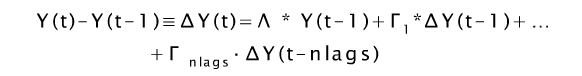

In this equation, we have multidimensional variables and hence the multiplication will be matrix multiplication. The coefficients for each of the lag terms in this equation are therefore vector terms.

In the Johansen test, we check whether lambda has a zero eigenvalue. When all the eigenvalues are zero, that would mean that the series are not cointegrated, whereas when some of the eigenvalues contain negative values, it would imply that a linear combination of the time series can be created, which would result in stationarity.

The linear combination of these prices represents the net market value of the portfolio. If the change in the value of the portfolio is related to its current value by a negative regression coefficient or in this case a negative eigenvalue, then we would have a mean reverting or stationary portfolio. This is the essence of the Johansen Test.

Fuente : https://blog.quantinsti.com/johansen-test-cointegration-building-stationary-portfolio/

#### Cointegration vs. Correlation

In quantitative trading, we usually work with non-stationary time-series. Often, people consider correlated for two assets when these assets co-move, but this term is mathematically incorrect in this context. Pearson’s correlation is defined for stationary variables only. As we see, this formula uses expected values and standard deviations, but these values are changing over time in non-stationary processes.

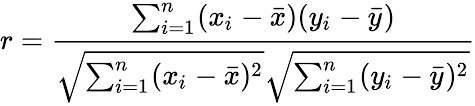

For these processes, we can define the cointegration. Cointegration refers to some stationary linear combination of several non-stationary time-series. Easy explanation you can find in this video https://youtu.be/vvTKjm94Ars

This picture shows two processes (X and Y), and their spread. This is an example of the correlation with no cointegration.

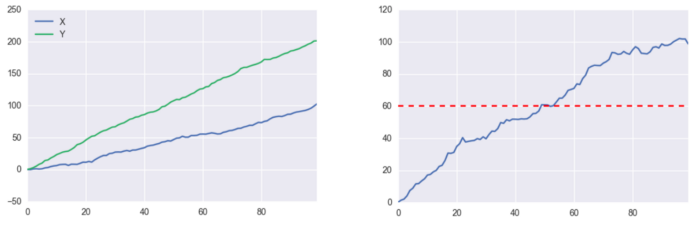

This example is vice versa (cointegration with no correlation)

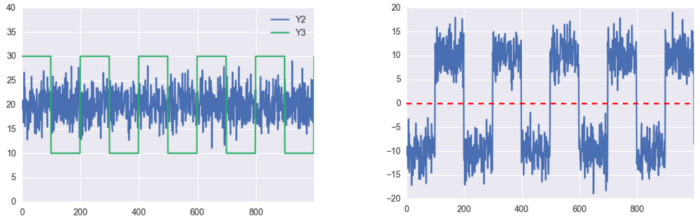

Fuente : https://towardsdatascience.com/pairs-trading-with-cryptocurrencies-e79b4a00b015

We then call the coint_johansen function by passing the data frame storing the time series data, 0 and 1 as its three arguments. The second term in the arguments represents the order of null hypothesis, a value of 0 implies that it is a constant term, there is no time trend in the polynomial. The third term specifies the number of lagged difference terms used when computing the estimator, here we use a single lagged difference term.

In [ ]:
for i in mcs:
    temp_df = macrodata[macrodata['mc'] == i].copy()
    temp_df = temp_df[['v_flow_mean', 'v_loss_cover', 'v_rainfall_total']]
    temp_df.head(10)

    print('MC = ', i)
   
    coint_johansen(temp_df, 0, 1)
    
    print('\n')

### Series transformation

A difference transform is a simple way for removing a systematic structure from the time series. We will remove trend by subtracting the previous value from each value in the series which is the first order differencing. To keep it simple, we will do first order differencing or seasonal differencing.

If we have an integrated order to n time series and if we take first order to difference and time, we will be left with series integrated order of zero.

In [ ]:
macrodata['v_flow_mean_log'] = np.log(macrodata['v_flow_mean'] + 1)
macrodata['v_loss_cover_log'] = np.log(macrodata['v_loss_cover'] + 1)
macrodata['v_rainfall_total_log'] = np.log(macrodata['v_rainfall_total'] + 1)

# data_train['v_flow_mean_log_diff'] = (data_train['v_flow_mean_log']).diff().dropna()
# data_train['v_loss_cover_log_diff'] = (data_train['v_loss_cover_log']).diff().dropna()
# data_train['v_rainfall_total_log_diff'] = (data_train['v_rainfall_total_log']).diff().dropna()

macrodata['v_flow_mean_log_diff'] = (macrodata['v_flow_mean_log']).diff()
macrodata['v_loss_cover_log_diff'] = (macrodata['v_loss_cover_log']).diff()
macrodata['v_rainfall_total_log_diff'] = (macrodata['v_rainfall_total_log']).diff()

In [ ]:
macrodata.describe()

In [ ]:
macrodata.head()

In [ ]:
temp_df = pd.DataFrame()

for i in mcs:
    temp_df = macrodata[macrodata['mc'] == i].copy()
    temp_df.set_index(keys = 'date', inplace = True)
    temp_df = temp_df[['v_flow_mean_log_diff', 'v_loss_cover_log_diff', 
                       'v_rainfall_total_log_diff']]
    temp_df.plot(figsize = (15,7), linewidth = 3, fontsize = 14)
    plt.title('MC = %s' % (i))
    plt.show()

After the transformations, the data should look like the following graph. Remember that the date (in this case year - month was defined as an index so that the printing was ordered)

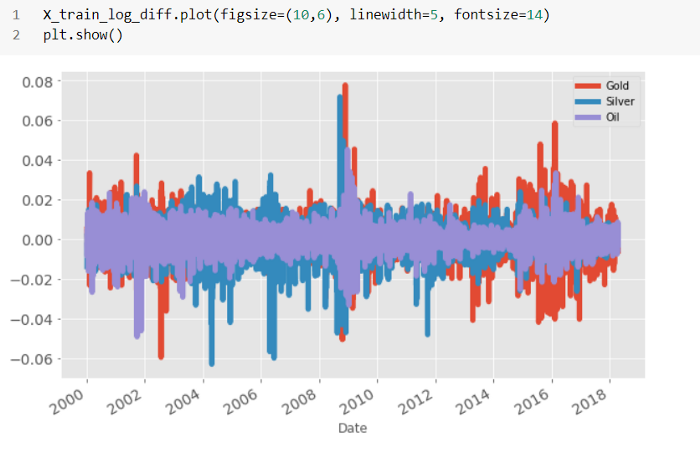

### Auto-Correlation Function Analysis of Transformed Series

In [ ]:
temp_df = pd.DataFrame()

var_log_dif = ['v_flow_mean_log_diff', 'v_loss_cover_log_diff', 'v_rainfall_total_log_diff']

for i in mcs:
    temp_df = macrodata[macrodata['mc'] == i].copy()
    temp_df.set_index(keys = 'date', inplace = True)
    temp_df = temp_df[var_log_dif]
    
    for j in var_log_dif:
        fig, ax = plt.subplots(1,2, figsize=(10,5))
        ax[0] = plot_acf(temp_df[j], lags = 75, ax = ax[0])
        plt.title('Autocorr. MC = %s - Variable : %s' % (i, j))
        ax[1] = plot_pacf(temp_df[j], lags = 75, ax = ax[1])
        plt.title('Part. Autocorr. MC = %s - Variable : %s' % (i, j))
        plt.show()
    
    

### Split data for machine learning algorithms

In [ ]:
temp_df = macrodata.copy()

data_train = pd.DataFrame()
data_test = pd.DataFrame()

for i in mcs:
    #train, test = train_test_split(temp_df[temp_df['mc'] == i], test_size = 0.2)
    nobs = 24 # 10% de 240
    train, test = temp_df[temp_df['mc'] == i].iloc[0:-nobs], temp_df[temp_df['mc'] == i].iloc[-nobs:]
    data_train = pd.concat([data_train, train], axis = 0)
    data_test = pd.concat([data_test, test], axis = 0)

print('Total data')
print('----------')
print(macrodata.shape)
print(macrodata.dtypes)
print()
print('data_train')
print('----------')
print(data_train.shape)
print(data_train.dtypes)
print()
print('data_test')
print('---------')
print(data_test.shape)
print(data_test.dtypes)

temp_df.head(10)

In [ ]:
data_train.head(10)

In [ ]:
data_test.head(10)

------------------

## VECM Estimation and Analysis

VECM imposes additional restriction due to the existence of non-stationary but co-integrated data forms. It utilizes the co-integration restriction information into its specifications. After the cointegration is known then the next test process is done by using error correction method. Through VECM we can interpret long term and short term equations. We need to determine the number of co-integrating relationships. The advantage of VECM over VAR is that the resulting VAR from VECM representation has more efficient coefficient estimates.

### Johansen Cointegration

In order to fit a VECM model, we need to determine the number of co-integrating relationships using a VEC rank test.

In [ ]:
df_stationary.fillna(-1, inplace = True)
df_stationary.reset_index(drop=True, inplace=True)
df_stationary.head(100)

In [ ]:
for i in mcs:
    temp_df = data_train[data_train['mc'] == i].copy()
    temp_df = temp_df[['v_flow_mean', 'v_loss_cover', 'v_rainfall_total']]

    try:
        vec_rank1 = var.vecm.select_coint_rank(temp_df, det_order = 1, k_ar_diff = 1, 
                                               method = 'trace', signif = 0.05)
        print('\nMC = %s' % i)
        print('=====================================\n')

        print(vec_rank1.summary())

    except Exception as exception:
        print('\nMC = %s' % i)
        print('=====================================')
        print(repr(exception).split('(')[1])
        print('=====================================\n')
        pass

In [ ]:
for i in mcs:
    temp_df = data_train[data_train['mc'] == i].copy()
    temp_df = temp_df[['v_flow_mean', 'v_loss_cover', 'v_rainfall_total']]

    try:
        vec_rank2 = var. vecm.select_coint_rank(temp_df, det_order = 1, k_ar_diff = 1, 
                                        method = 'maxeig', signif = 0.05)
        print('\nMC = %s' % i)
        print('=====================================\n')

        print(vec_rank1.summary())

    except Exception as exception:
        print('\nMC = %s' % i)
        print('=====================================')
        print(repr(exception).split('(')[1])
        print('=====================================\n')
        pass

**Interpretation**

The Johansen test is a test for cointegration of several I(1) time series data. “Cointegration” is the property of two time series data where both share common stochastic drift. Stochastic drift is the change in average value of the random or stochastic process. The advantage of the Johansen test comes from its ability to handle several time series variable; in contrast, the Engle-Granger test could handle only one cointegration relationship. The Johansen test relies on two types of tests: (i) trace test and (ii) maximum eigenvalue test. Assume that there is a vector autoregression (VAR) of order p:

(1)   $y_t = mu + A_1y_{t-1} + … + A_py_{t-p} + e_t$

Where y is n x 1 (n by 1) vector that are integrated of order 1 or commonly written as I(1), and et is n x 1 vector of innovations. Equation can be rewritten as:

(2)   $\hat{y}_t = mu + Py_{t-1} + \sum(G_i \hat{y}_{t-I}) + e_t$


where $P = \sum(A_i – I) \hspace{0.5cm} and \hspace{0.5cm} Gi = -\sum(A_j)$


The coefficient P has a reduced rank r < n; thus, there exists n x r matrices alpha (a) and beta (b) with rank r such that P = ab’ and b’y is stationary. Recall that r is the number of relationships. The elements of a is known as the adjustment parameters in the vector error correction model (VECM), b is the vector column of cointegrating vector. The objective is to show that for a given r “what is the likelihood estimator of b defining the combination vector $y_{t-1}$ that produces r the largest conanical correlations of $\hat{y}_t$ with $y_{t-1}$ ?” In answer this question the trace test and eigenvalue test are used.

(4)   $J_{trace} = -T(\sum(ln(1 – L_i))$

(5)   $J_{max} = -T ln(l - L_{r+1})$

… where T = sample size, L is the largest canonical correlation. Under the trace test, the null hypothesis of r conintegrating vectors against the alternative hypothesis n cointegrating vectors. Under the eigenvalue test, the null hypothesis of r conintegrating vector against the alternative hypothesis of r + 1 cointegrating vectors.

INTERPRETATION

From the two tests, read the largest canonical correlation of $\hat{y}_t$ with $y_{t-1}$. Both trace test and eigenvalue test are based on pure unit root assumption. When the variables are near-unit-root process, this assumption will not be correct. The interpretation is the interpretation of correlation. However, in this case, the correlation is a correlation for vector variables in time series. The objective of the test is to verify if the two variables---in this case spot price and future price---have a common stochastic drift. The rationale of the test is that any variable that is not I(1) or a pure unit root process is a stationary I(0) process.

REFERENCES:

Johansen, Søren (1991). "Estimation and Hypothesis Testing of Cointegration Vectors in Gaussian Vector Autoregressive Models". Econometrica 59 (6): 1551–1580. JSTOR 2938278.




Source : https://www.researchgate.net/post/How_do_I_interpret_trace_statistic_and_Max-Eigen_statistics_in_the_Johansen_cointegration_test

Hypothesis


$H_o$ : There is a unit root, or no cointegration.

$H_a$ : The series has cointegration


In the Johansen cointegration test; When we use trace test statistic and eigenvalue test statistic we find that the test statistics are greater than the critical values, therefore the probability of making mistakes rejecting the null hypothesis is very small; therefore we reject it: **The series do have cointegration, therefore it is valid to run a Vector Error Correction Model (VECM).**

In [ ]:
dates = pd.DataFrame(pd.date_range('2018-01-01','2019-12-31' , freq='1M') - 
             pd.offsets.MonthBegin(1))
dates.columns = ['date']

dates['year'] = pd.DatetimeIndex(dates['date']).year
dates['month'] = pd.DatetimeIndex(dates['date']).month

dates.head()

### VECM (Vector Error Correction Model)

In [ ]:
def VECM_complete(mbasin, train, test, diff = 12, coint_r = 3, determ = 'ci'):

    forecast_steps = test[test['mc'] == mbasin].shape[0]

    temp_df = train[train['mc'] == mbasin].copy()
    temp_df = temp_df[['v_flow_mean', 'v_loss_cover', 'v_rainfall_total']]
    temp_df.reset_index(drop=True, inplace=True)
    
    print(mbasin, temp_df.shape, temp_df.v_flow_mean.mean())

    vecm = var.vecm.VECM(endog = temp_df, k_ar_diff = diff, coint_rank = coint_r, 
                         deterministic = determ)
    vecm_fit = vecm.fit()
    vecm_fit.predict(steps = forecast_steps)
#     print(vecm_fit.predict(steps = forecast_steps))
    
    forecast, lower, upper = vecm_fit.predict(steps = forecast_steps, alpha = 0.05)
#     print('lower bounds of confidence intervals:')
#     print(lower.round(3))
#     print('\npoint forecasts:')
#     print(forecast.round(3))
#     print('\nupper bounds of confidence intervals:')
#     print(upper.round(3))

    df_lower = pd.DataFrame(lower, columns = ['v_flow_mean_lower', 'v_loss_cover_lower', 
                                              'v_rainfall_total_lower'])
    df_forecast = pd.DataFrame(forecast, columns = ['v_flow_mean_mean', 'v_loss_cover_mean', 
                                              'v_rainfall_total_mean'])
    df_upper = pd.DataFrame(upper, columns = ['v_flow_mean_upper', 'v_loss_cover_upper', 
                                              'v_rainfall_total_upper'])
    df_forecast_complete = pd.concat([dates, df_lower, df_forecast, df_upper], axis = 1)

#     name_file = '../temp/VECM_MC_' + str(mbasin) + '.zip'
#     df_forecast_complete.to_csv(name_file, index = False, compression = 'zip')

#     name_file = '../temp/VECM_MC_' + str(mbasin) + '.csv'
#     df_forecast_complete.to_csv(name_file, index = False)
    
    temp_df = test[test['mc'] == mbasin].copy()
    temp_df = temp_df[['v_flow_mean', 'v_loss_cover', 'v_rainfall_total']]
    temp_df.reset_index(drop=True, inplace=True)

    df_forecast = pd.DataFrame(forecast, columns = ['v_flow_mean', 'v_loss_cover', 
                                                    'v_rainfall_total'])
   
    print(mbasin, temp_df.shape, temp_df.v_flow_mean.mean(), temp_df.v_loss_cover.mean(),
         temp_df.v_rainfall_total.mean(), df_forecast.v_flow_mean.mean())

    forecast_errors = [temp_df.v_flow_mean.iloc[i] - df_forecast.v_flow_mean.iloc[i] 
                       for i in range(forecast_steps)]
    bias = sum(forecast_errors) * 1.0 / (forecast_steps)
#     print('Bias : %f' % bias)

    mae = skm.mean_absolute_error(temp_df.v_flow_mean, df_forecast.v_flow_mean)
#     print('MAE : %f' % mae)

    mse = skm.mean_squared_error(temp_df.v_flow_mean, df_forecast.v_flow_mean)
    rmse = np.sqrt(mse)
#     print('MSE : %f' % mse)
#     print('RMSE : %f' % rmse) 
    
    resultados = [mbasin, bias, mae, mse, rmse]
    resultados = pd.DataFrame([resultados], columns = ['mc', 'Bias', 'MAE', 'MSE', 'RMSE'])
    
#     print(resultados.head())
#     print('===========================================================\n')

    prediction = pd.concat([df_forecast_complete, temp_df], axis = 1)
    prediction['mc'] = mbasin
    prediction = prediction[['date', 'year', 'month', 'mc', 'v_flow_mean_lower', 
                             'v_flow_mean_mean', 'v_flow_mean_upper', 
                             'v_flow_mean', 'v_loss_cover', 'v_rainfall_total']]

#     vecm_fit.plot_forecast(steps = forecast_steps, n_last_obs = forecast_steps)
    
    return (resultados, prediction)

# VECM_complete(10, data_train, data_test, 12, 3, 'ci')

In [ ]:
VECM_metrics = pd.DataFrame()
VECM_prediction = pd.DataFrame()

for i, mbasin in enumerate(mcs):
    metrics, prediction = VECM_complete(mbasin, data_train, data_test, 12, 3, 'ci')
    VECM_metrics = pd.concat([VECM_metrics, metrics], axis = 0)
    VECM_prediction = pd.concat([VECM_prediction, prediction], axis = 0)

In [ ]:
VECM_metrics.to_csv('../model/VECM_results_v1.csv', index = False)
VECM_metrics.head()

In [ ]:
VECM_prediction['v_flow_mean_mean'] = VECM_prediction['v_flow_mean_mean'].apply(lambda x: 
                                                                              0.01 if x <= 0 
                                                                              else x)
VECM_prediction.to_csv('../model/VECM_predictions_v1.csv', index = False)

VECM_prediction.head()

------------------

### VECM (Vector Error Correction Model) - Prediction 2020 - 2021

#### Read scenarios for independent variables

In [9]:
scenarios = pd.read_excel('../data/matrix/Esc_Predicciones_longitudinal.xlsx')

scenarios['v_flow_mean'] = 0

scenarios = scenarios[['date', 'mc', 'v_flow_mean', 'v_loss_cover', 'v_rainfall_total', 
                       'scenario']]

scenarios.head(10)

date  mc  v_flow_mean  v_loss_cover  v_rainfall_total      scenario
0  2020-01-01   1            0       0.07693            210.44  Def_25%_P_A1
1  2020-02-01   1            0       0.07702            135.49  Def_25%_P_A1
2  2020-03-01   1            0       0.07710            259.40  Def_25%_P_A1
3  2020-04-01   1            0       0.07718             61.71  Def_25%_P_A1
4  2020-05-01   1            0       0.07726            202.86  Def_25%_P_A1
5  2020-06-01   1            0       0.07735            137.33  Def_25%_P_A1
6  2020-07-01   1            0       0.07743             14.20  Def_25%_P_A1
7  2020-08-01   1            0       0.07751             20.29  Def_25%_P_A1
8  2020-09-01   1            0       0.07759              3.46  Def_25%_P_A1
9  2020-10-01   1            0       0.07768             78.47  Def_25%_P_A1

In [10]:
dates = pd.DataFrame(pd.date_range('2020-01-01','2021-12-31' , freq='1M') - 
             pd.offsets.MonthBegin(1))
dates.columns = ['date']

dates['year'] = pd.DatetimeIndex(dates['date']).year
dates['month'] = pd.DatetimeIndex(dates['date']).month

dates.head()

date  year  month
0 2020-01-01  2020      1
1 2020-02-01  2020      2
2 2020-03-01  2020      3
3 2020-04-01  2020      4
4 2020-05-01  2020      5

In [14]:
def VECM_complete_pred(mbasin, train, test, diff = 12, coint_r = 3, determ = 'ci'):

    forecast_steps = test[test['mc'] == mbasin].shape[0]

    temp_df = train[train['mc'] == mbasin].copy()
    temp_df = temp_df[['v_flow_mean', 'v_loss_cover', 'v_rainfall_total']]
    temp_df['v_loss_cover'] = temp_df['v_loss_cover'] * 100
    temp_df.reset_index(drop=True, inplace=True)
    
    temp_df_test = test[test['mc'] == mbasin].copy()
    temp_df_test = temp_df_test[['v_flow_mean', 'v_loss_cover', 'v_rainfall_total']]
    temp_df_test['v_loss_cover'] = temp_df_test['v_loss_cover'] * 100
    temp_df_test.reset_index(drop=True, inplace=True)
    
    temp_df = pd.concat([temp_df, temp_df_test])
    
#     # Differencing time series
#     # =================================================================
        
#     print('Differencing TS')
    
#     temp_df_ff = temp_df[:1]
#     temp_df = temp_df.diff().dropna()

#     print(temp_df_ff.shape)
#     print(temp_df_ff.head())
    
#     print(temp_df.shape)
#     print(temp_df.head())
#     # =================================================================
    
#     print(mbasin, temp_df.shape, temp_df.v_flow_mean.mean())

    vecm = var.vecm.VECM(endog = temp_df, k_ar_diff = diff, coint_rank = coint_r, 
                         deterministic = determ)
    vecm_fit = vecm.fit()
    vecm_fit.predict(steps = forecast_steps)
#     print(vecm_fit.predict(steps = forecast_steps))
    
    forecast, lower, upper = vecm_fit.predict(steps = forecast_steps, alpha = 0.05)

    df_lower = pd.DataFrame(lower, columns = ['v_flow_mean_lower', 'v_loss_cover_lower', 
                                              'v_rainfall_total_lower'])
    df_forecast = pd.DataFrame(forecast, columns = ['v_flow_mean_mean', 'v_loss_cover_mean', 
                                              'v_rainfall_total_mean'])
    df_upper = pd.DataFrame(upper, columns = ['v_flow_mean_upper', 'v_loss_cover_upper', 
                                              'v_rainfall_total_upper'])
    df_forecast_complete = pd.concat([dates, df_lower, df_forecast, df_upper], axis = 1)

#     # Reverser Differencing time series
#     # =================================================================
#     print('UnDifferencing TS')
#     df_forecast = df_forecast[['v_flow_mean_mean', 'v_loss_cover_mean', 
#                                'v_rainfall_total_mean']]
#     temp_df_ff.rename(columns = {'v_flow_mean':'v_flow_mean_mean', 
#                        'v_loss_cover' : 'v_loss_cover_mean',
#                        'v_rainfall_total':'v_rainfall_total_mean'}, inplace = True)
#     df_forecast = pd.concat([temp_df_ff, df_forecast], axis = 0)
#     df_forecast = temp_df.cumsum()
#     print(df_forecast.shape)
#     print(df_forecast.head())
#     # =================================================================
    
#     name_file = '../temp/VECM_MC_' + str(mbasin) + '.zip'
#     df_forecast_complete.to_csv(name_file, index = False, compression = 'zip')

#     name_file = '../temp/VECM_MC_' + str(mbasin) + '.csv'
#     df_forecast_complete.to_csv(name_file, index = False)
    
    temp_df = test[test['mc'] == mbasin].copy()
    temp_df = temp_df[['v_flow_mean', 'v_loss_cover', 'v_rainfall_total']]
    temp_df_org = temp_df['v_loss_cover'] = temp_df['v_loss_cover'] * 100
    temp_df.reset_index(drop=True, inplace=True)

    prediction = pd.concat([df_forecast_complete, temp_df], axis = 1)
    prediction['mc'] = mbasin
    prediction = prediction[['date', 'year', 'month', 'mc', 'v_flow_mean_lower', 
                             'v_flow_mean_mean', 'v_flow_mean_upper', 
                             'v_flow_mean', 'v_loss_cover', 'v_rainfall_total']]

#     print(mbasin, prediction.shape, prediction.v_flow_mean_mean.mean(), 
#          prediction.v_loss_cover.mean(), prediction.v_rainfall_total.mean())
    
    print('MC = %s' % mbasin)
    print(prediction.head())
    
#     vecm_fit.plot_forecast(steps = forecast_steps, n_last_obs = forecast_steps)
    
    return (prediction)

# VECM_complete(10, data_train, data_test, 12, 3, 'ci')

In [15]:
escen = scenarios['scenario'].unique()

data_train_predict = macrodata.copy()

VECM_prediction = pd.DataFrame()

for j in escen:
    
    data_test_predict = scenarios[scenarios['scenario'] == j].copy()

    for i, mbasin in enumerate(mcs):
        
        print('\n==================================')
        print('Escenario :', j, '\n')
        
        prediction = VECM_complete_pred(mbasin, data_train_predict, data_test_predict,
                                        12, 3, 'ci')
        prediction['scenario'] = j
        prediction.drop(columns = ['v_flow_mean_lower', 'v_flow_mean_mean',
                                   'v_flow_mean'], inplace = True)
        prediction.rename(columns = {'v_flow_mean_upper':'v_flow_mean_forecast'}, 
                          inplace = True)
        prediction.columns = ['date', 'year', 'month', 'mc', 'v_flow_mean_forecast', 
                              'v_loss_cover', 'v_rainfall_total', 'scenario']        
        VECM_prediction = pd.concat([VECM_prediction, prediction], axis = 0)


Escenario : Def_25%_P_A1 

MC = 1
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1   1          -2.436501         -0.677071   
1 2020-02-01  2020      2   1          -2.800171         -0.885726   
2 2020-03-01  2020      3   1          -2.709413         -0.674226   
3 2020-04-01  2020      4   1          -2.543610         -0.465061   
4 2020-05-01  2020      5   1          -2.112971         -0.008499   

   v_flow_mean_upper  v_flow_mean  v_loss_cover  v_rainfall_total  
0           1.082358            0         7.693            210.44  
1           1.028720            0         7.702            135.49  
2           1.360960            0         7.710            259.40  
3           1.613487            0         7.718             61.71  
4           2.095972            0         7.726            202.86  

Escenario : Def_25%_P_A1 

MC = 2
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1   2  

/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsuppor

MC = 7
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1   7        -143.165424        -37.993230   
1 2020-02-01  2020      2   7        -167.069351        -46.307610   
2 2020-03-01  2020      3   7        -141.403740        -11.023362   
3 2020-04-01  2020      4   7        -102.739705         34.470603   
4 2020-05-01  2020      5   7         -61.964730         81.050794   

   v_flow_mean_upper  v_flow_mean  v_loss_cover  v_rainfall_total  
0          67.178964            0         3.477            186.36  
1          74.454131            0         3.481            213.38  
2         119.357015            0         3.484             49.39  
3         171.680912            0         3.488            438.88  
4         224.066319            0         3.491            276.37  

Escenario : Def_25%_P_A1 

MC = 8
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1   8         -28.349130         -9

/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsuppor

        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  16        -318.416067        -63.905065   
1 2020-02-01  2020      2  16        -347.300204        -43.730920   
2 2020-03-01  2020      3  16        -336.733617        -15.751212   
3 2020-04-01  2020      4  16        -304.560299         22.416475   
4 2020-05-01  2020      5  16        -256.461803         72.755425   

   v_flow_mean_upper  v_flow_mean  v_loss_cover  v_rainfall_total  
0         190.605937            0        10.128            100.29  
1         259.838365            0        10.139             17.60  
2         305.231192            0        10.150            125.94  
3         349.393249            0        10.160            243.17  
4         401.972654            0        10.171            291.36  

Escenario : Def_25%_P_A1 

MC = 17
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  17          -3.656784          1.86993

/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsuppor



Escenario : Def_25%_P_A1 

MC = 27
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  27         -27.842351         -1.766498   
1 2020-02-01  2020      2  27         -27.327599          4.098534   
2 2020-03-01  2020      3  27         -31.405782          1.943735   
3 2020-04-01  2020      4  27         -22.827723         10.991192   
4 2020-05-01  2020      5  27         -24.657962          9.228948   

   v_flow_mean_upper  v_flow_mean  v_loss_cover  v_rainfall_total  
0          24.309355            0         4.434            152.83  
1          35.524667            0         4.439             46.41  
2          35.293251            0         4.443            119.79  
3          44.810106            0         4.448            104.60  
4          43.115859            0         4.453            128.21  

Escenario : Def_25%_P_A1 

MC = 28
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  2

/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsuppor

MC = 35
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  35        -245.242639        -73.789269   
1 2020-02-01  2020      2  35        -203.713701        -16.390278   
2 2020-03-01  2020      3  35        -163.881737         30.265019   
3 2020-04-01  2020      4  35        -142.216785         58.504752   
4 2020-05-01  2020      5  35        -141.041357         68.827317   

   v_flow_mean_upper  v_flow_mean  v_loss_cover  v_rainfall_total  
0          97.664101            0         9.518            245.69  
1         170.933144            0         9.527             91.90  
2         224.411775            0         9.536            245.81  
3         259.226289            0         9.545            319.50  
4         278.695991            0         9.554            466.05  

Escenario : Def_25%_P_A1 

MC = 36
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  36        -101.196620         

/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsuppor

MC = 45
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  45        -567.792659        -19.997010   
1 2020-02-01  2020      2  45        -748.546035       -104.912328   
2 2020-03-01  2020      3  45        -965.196841       -299.978713   
3 2020-04-01  2020      4  45        -959.265485       -289.473182   
4 2020-05-01  2020      5  45        -943.458170       -246.217351   

   v_flow_mean_upper  v_flow_mean  v_loss_cover  v_rainfall_total  
0         527.798638            0        18.443             75.04  
1         538.721380            0        18.462             49.70  
2         365.239415            0        18.481            282.63  
3         380.319122            0        18.500            493.14  
4         451.023467            0        18.520            432.72  

Escenario : Def_25%_P_A1 

MC = 46
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  46       -1303.155994         

/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsuppor



Escenario : Def_50%_P_A1 

MC = 7
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1   7        -143.370911        -37.740490   
1 2020-02-01  2020      2   7        -169.348384        -47.627404   
2 2020-03-01  2020      3   7        -147.148939        -15.742076   
3 2020-04-01  2020      4   7        -107.342543         30.672319   
4 2020-05-01  2020      5   7         -67.681720         75.978198   

   v_flow_mean_upper  v_flow_mean  v_loss_cover  v_rainfall_total  
0          67.889932            0         3.481            186.36  
1          74.093575            0         3.488            213.38  
2         115.664787            0         3.495             49.39  
3         168.687180            0         3.502            438.88  
4         219.638117            0         3.509            276.37  

Escenario : Def_50%_P_A1 

MC = 8
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1   8 

/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsuppor

MC = 15
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  15         -75.406493        -15.641050   
1 2020-02-01  2020      2  15         -91.755757        -23.113703   
2 2020-03-01  2020      3  15         -86.292684        -16.126261   
3 2020-04-01  2020      4  15         -70.180566          0.208816   
4 2020-05-01  2020      5  15         -52.768262         18.338379   

   v_flow_mean_upper  v_flow_mean  v_loss_cover  v_rainfall_total  
0          44.124393            0        20.593            113.78  
1          45.528351            0        20.636             21.81  
2          54.040162            0        20.680            138.49  
3          70.598198            0        20.723            278.03  
4          89.445019            0        20.767            334.23  

Escenario : Def_50%_P_A1 

MC = 16
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  16        -311.853841        -

/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsuppor



Escenario : Def_50%_P_A1 

MC = 24
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  24         -25.024304         -6.317207   
1 2020-02-01  2020      2  24         -29.215522         -7.064177   
2 2020-03-01  2020      3  24         -31.004983         -8.111218   
3 2020-04-01  2020      4  24         -24.815192         -1.254374   
4 2020-05-01  2020      5  24         -19.487551          4.897642   

   v_flow_mean_upper  v_flow_mean  v_loss_cover  v_rainfall_total  
0          12.389889            0        17.806             86.14  
1          15.087168            0        17.841             58.00  
2          14.782548            0        17.877            224.49  
3          22.306445            0        17.912            209.96  
4          29.282834            0        17.948            118.81  

Escenario : Def_50%_P_A1 

MC = 25
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  2

/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsuppor

MC = 33
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  33          -2.129830          0.068070   
1 2020-02-01  2020      2  33          -2.674579          0.076947   
2 2020-03-01  2020      3  33          -3.425513         -0.432320   
3 2020-04-01  2020      4  33          -4.029060         -0.845027   
4 2020-05-01  2020      5  33          -3.344286          0.113970   

   v_flow_mean_upper  v_flow_mean  v_loss_cover  v_rainfall_total  
0           2.265970            0         2.662            341.53  
1           2.828474            0         2.667            284.57  
2           2.560873            0         2.673            380.03  
3           2.339006            0         2.678            187.77  
4           3.572226            0         2.684            199.62  

Escenario : Def_50%_P_A1 

MC = 34
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  34        -211.371384        -

/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsuppor


Escenario : Def_50%_P_A1 

MC = 43
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  43        -588.269985       -178.974169   
1 2020-02-01  2020      2  43        -777.798559       -325.742424   
2 2020-03-01  2020      3  43        -800.708861       -325.836039   
3 2020-04-01  2020      4  43        -898.525268       -410.629454   
4 2020-05-01  2020      5  43        -916.695429       -424.429118   

   v_flow_mean_upper  v_flow_mean  v_loss_cover  v_rainfall_total  
0         230.321646            0         1.332            574.84  
1         126.313710            0         1.335            356.82  
2         149.036783            0         1.338            421.65  
3          77.266361            0         1.341            496.14  
4          67.837192            0         1.344            567.31  

Escenario : Def_50%_P_A1 

MC = 44
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  44

/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsuppor


Escenario : Def_75%_P_A1 

MC = 5
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1   5         -22.346890          8.538378   
1 2020-02-01  2020      2   5         -31.557667          4.700734   
2 2020-03-01  2020      3   5         -41.149622         -0.435103   
3 2020-04-01  2020      4   5         -39.998101          3.679381   
4 2020-05-01  2020      5   5         -34.286079         11.752395   

   v_flow_mean_upper  v_flow_mean  v_loss_cover  v_rainfall_total  
0          39.423645            0         3.258              0.00  
1          40.959135            0         3.268             31.55  
2          40.279416            0         3.278             58.59  
3          47.356864            0         3.287             57.61  
4          57.790870            0         3.297            215.49  

Escenario : Def_75%_P_A1 

MC = 6
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1   6  

/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsuppor

MC = 14
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  14         -42.395382          1.649208   
1 2020-02-01  2020      2  14         -39.352184         11.058096   
2 2020-03-01  2020      3  14         -48.483176          3.579018   
3 2020-04-01  2020      4  14         -45.548069          6.667684   
4 2020-05-01  2020      5  14         -39.331982         13.647694   

   v_flow_mean_upper  v_flow_mean  v_loss_cover  v_rainfall_total  
0          45.693798            0         1.754             94.94  
1          61.468376            0         1.760             24.17  
2          55.641211            0         1.765            188.52  
3          58.883437            0         1.770            215.72  
4          66.627371            0         1.775            330.81  

Escenario : Def_75%_P_A1 

MC = 15
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  15         -76.781630        -

/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsuppor

MC = 23
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  23        -139.434408        -33.954351   
1 2020-02-01  2020      2  23        -157.838394        -37.345983   
2 2020-03-01  2020      3  23        -162.037819        -36.239001   
3 2020-04-01  2020      4  23        -154.018646        -23.948738   
4 2020-05-01  2020      5  23        -109.362078         22.486983   

   v_flow_mean_upper  v_flow_mean  v_loss_cover  v_rainfall_total  
0          71.525706            0         4.879             79.32  
1          83.146427            0         4.894            107.24  
2          89.559817            0         4.909              0.00  
3         106.121169            0         4.924            166.87  
4         154.336044            0         4.939            358.47  

Escenario : Def_75%_P_A1 

MC = 24
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  24         -24.578551         

/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsuppor

MC = 33
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  33          -2.222628         -0.023612   
1 2020-02-01  2020      2  33          -2.846599         -0.096424   
2 2020-03-01  2020      3  33          -3.566663         -0.575837   
3 2020-04-01  2020      4  33          -4.156187         -0.976969   
4 2020-05-01  2020      5  33          -3.521016         -0.071076   

   v_flow_mean_upper  v_flow_mean  v_loss_cover  v_rainfall_total  
0           2.175403            0         2.665            341.53  
1           2.653751            0         2.673            284.57  
2           2.414989            0         2.681            380.03  
3           2.202249            0         2.689            187.77  
4           3.378864            0         2.698            199.62  

Escenario : Def_75%_P_A1 

MC = 34
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  34        -211.195066        -

/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsuppor

MC = 44
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  44       -1376.377285       -426.343113   
1 2020-02-01  2020      2  44       -1780.303031       -635.641825   
2 2020-03-01  2020      3  44       -1999.019947       -782.524334   
3 2020-04-01  2020      4  44       -2010.869841       -755.338154   
4 2020-05-01  2020      5  44       -1831.457330       -535.088863   

   v_flow_mean_upper  v_flow_mean  v_loss_cover  v_rainfall_total  
0         523.691058            0         0.860            580.60  
1         509.019381            0         0.863            416.53  
2         433.971279            0         0.866            415.40  
3         500.193532            0         0.869            504.97  
4         761.279604            0         0.872            520.39  

Escenario : Def_75%_P_A1 

MC = 45
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  45        -571.564747        -

/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsuppor

MC = 5
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1   5         -20.860651         10.071086   
1 2020-02-01  2020      2   5         -30.857807          5.529247   
2 2020-03-01  2020      3   5         -38.738086          2.125492   
3 2020-04-01  2020      4   5         -38.909094          4.894405   
4 2020-05-01  2020      5   5         -32.523538         13.584367   

   v_flow_mean_upper  v_flow_mean  v_loss_cover  v_rainfall_total  
0          41.002822            0         3.261              0.00  
1          41.916301            0         3.274             31.55  
2          42.989070            0         3.287             58.59  
3          48.697903            0         3.300             57.61  
4          59.692272            0         3.313            215.49  

Escenario : Def_100%_P_A1 

MC = 6
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1   6         -22.594400         -

/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsuppor

MC = 16
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  16        -304.472590        -49.729676   
1 2020-02-01  2020      2  16        -328.086042        -23.869339   
2 2020-03-01  2020      3  16        -329.787827         -7.156966   
3 2020-04-01  2020      4  16        -300.557541         26.228536   
4 2020-05-01  2020      5  16        -254.691311         74.325670   

   v_flow_mean_upper  v_flow_mean  v_loss_cover  v_rainfall_total  
0         205.013238            0        10.160            100.29  
1         280.347364            0        10.203             17.60  
2         315.473894            0        10.246            125.94  
3         353.014613            0        10.289            243.17  
4         403.342652            0        10.332            291.36  

Escenario : Def_100%_P_A1 

MC = 17
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  17          -3.657616        

/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsuppor

MC = 27
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  27         -28.734561         -2.667096   
1 2020-02-01  2020      2  27         -28.307278          3.097046   
2 2020-03-01  2020      3  27         -32.074115          1.267771   
3 2020-04-01  2020      4  27         -23.586018         10.214635   
4 2020-05-01  2020      5  27         -25.657760          8.190914   

   v_flow_mean_upper  v_flow_mean  v_loss_cover  v_rainfall_total  
0          23.400368            0         4.448            152.83  
1          34.501369            0         4.467             46.41  
2          34.609658            0         4.486            119.79  
3          44.015289            0         4.505            104.60  
4          42.039588            0         4.524            128.21  

Escenario : Def_100%_P_A1 

MC = 28
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  28         -49.521074        

/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsuppor

MC = 38
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  38         -33.458790         -6.628524   
1 2020-02-01  2020      2  38         -48.151672        -15.947673   
2 2020-03-01  2020      3  38         -49.202604        -14.539168   
3 2020-04-01  2020      4  38         -42.612249         -6.275406   
4 2020-05-01  2020      5  38         -37.507765          0.036041   

   v_flow_mean_upper  v_flow_mean  v_loss_cover  v_rainfall_total  
0          20.201742            0         2.399            148.56  
1          16.256327            0         2.409             77.27  
2          20.124268            0         2.419             74.91  
3          30.061438            0         2.429            153.53  
4          37.579847            0         2.439            130.44  

Escenario : Def_100%_P_A1 

MC = 39
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  39        -417.102814        

/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsuppor

MC = 48
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  48       -1978.975007       -513.327063   
1 2020-02-01  2020      2  48       -2260.355501       -288.363402   
2 2020-03-01  2020      3  48       -2638.043063       -407.835399   
3 2020-04-01  2020      4  48       -3298.638948       -939.760448   
4 2020-05-01  2020      5  48       -3408.615650      -1001.962261   

   v_flow_mean_upper  v_flow_mean  v_loss_cover  v_rainfall_total  
0         952.320881            0         6.659            100.27  
1        1683.628697            0         6.686             12.08  
2        1822.372265            0         6.713            177.84  
3        1419.118051            0         6.740            514.19  
4        1404.691129            0         6.767            459.78  

Escenario : Def_25%_P_A2 

MC = 1
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1   1          -2.409313         -

/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsuppor



Escenario : Def_25%_P_A2 

MC = 8
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1   8         -28.491785         -9.220080   
1 2020-02-01  2020      2   8         -33.837714        -11.366644   
2 2020-03-01  2020      3   8         -34.641643         -9.858146   
3 2020-04-01  2020      4   8         -28.438389         -2.806787   
4 2020-05-01  2020      5   8         -16.910653          9.611965   

   v_flow_mean_upper  v_flow_mean  v_loss_cover  v_rainfall_total  
0          10.051624            0         2.315            469.71  
1          11.104427            0         2.318            159.19  
2          14.925351            0         2.320            248.15  
3          22.824816            0         2.323            300.97  
4          36.134582            0         2.325            279.80  

Escenario : Def_25%_P_A2 

MC = 9
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1   9 

/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsuppor

MC = 18
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  18         -47.865489        -21.186143   
1 2020-02-01  2020      2  18         -50.213347        -17.358366   
2 2020-03-01  2020      3  18         -48.547151        -11.054595   
3 2020-04-01  2020      4  18         -41.734723         -2.482602   
4 2020-05-01  2020      5  18         -43.713288         -3.351574   

   v_flow_mean_upper  v_flow_mean  v_loss_cover  v_rainfall_total  
0           5.493204            0        18.622             47.02  
1          15.496615            0        18.641              0.00  
2          26.437961            0        18.660            151.63  
3          36.769519            0        18.679            306.14  
4          37.010140            0        18.698            377.15  

Escenario : Def_25%_P_A2 

MC = 19
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  19         -14.042734         

/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsuppor


Escenario : Def_25%_P_A2 

MC = 29
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  29         -35.726762        -13.704243   
1 2020-02-01  2020      2  29         -35.860683        -12.560167   
2 2020-03-01  2020      3  29         -29.386387         -5.294448   
3 2020-04-01  2020      4  29         -36.222246        -11.025137   
4 2020-05-01  2020      5  29         -33.446753         -6.529855   

   v_flow_mean_upper  v_flow_mean  v_loss_cover  v_rainfall_total  
0           8.318275            0         1.790            680.48  
1          10.740350            0         1.792            672.60  
2          18.797491            0         1.794            515.36  
3          14.171971            0         1.795            504.68  
4          20.387042            0         1.797            851.66  

Escenario : Def_25%_P_A2 

MC = 30
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  30

/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsuppor

MC = 39
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  39        -458.599675        -18.920303   
1 2020-02-01  2020      2  39        -537.073794         17.437621   
2 2020-03-01  2020      3  39        -567.324901         33.373016   
3 2020-04-01  2020      4  39        -542.952753         81.750371   
4 2020-05-01  2020      5  39        -348.842069        294.728570   

   v_flow_mean_upper  v_flow_mean  v_loss_cover  v_rainfall_total  
0         420.759068            0         2.678            110.62  
1         571.949035            0         2.681              7.82  
2         634.070932            0         2.683            192.02  
3         706.453495            0         2.686            461.50  
4         938.299209            0         2.689            569.45  

Escenario : Def_25%_P_A2 

MC = 40
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  40        -858.112913        -

/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsuppor


Escenario : Def_50%_P_A2 

MC = 2
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1   2         -18.969106         -4.867529   
1 2020-02-01  2020      2   2         -19.404821         -2.240757   
2 2020-03-01  2020      3   2         -13.493737          4.454996   
3 2020-04-01  2020      4   2          -9.163691          8.954683   
4 2020-05-01  2020      5   2          -8.816583          9.464629   

   v_flow_mean_upper  v_flow_mean  v_loss_cover  v_rainfall_total  
0           9.234048            0         6.123            273.43  
1          14.923307            0         6.135            150.85  
2          22.403730            0         6.147            234.07  
3          27.073057            0         6.159            190.35  
4          27.745840            0         6.171            207.66  

Escenario : Def_50%_P_A2 

MC = 3
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1   3  

/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsuppor

MC = 12
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  12          -6.036336          0.413756   
1 2020-02-01  2020      2  12          -7.861734          1.299698   
2 2020-03-01  2020      3  12          -9.657128          1.448100   
3 2020-04-01  2020      4  12          -8.761679          3.074662   
4 2020-05-01  2020      5  12          -7.891597          4.108939   

   v_flow_mean_upper  v_flow_mean  v_loss_cover  v_rainfall_total  
0           6.863849            0         3.200             76.45  
1          10.461129            0         3.207             50.71  
2          12.553329            0         3.214             69.52  
3          14.911004            0         3.221            117.15  
4          16.109475            0         3.228            216.95  

Escenario : Def_50%_P_A2 

MC = 13
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  13        -158.957969        -

/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsuppor


Escenario : Def_50%_P_A2 

MC = 23
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  23        -141.251766        -36.064752   
1 2020-02-01  2020      2  23        -159.019595        -39.592153   
2 2020-03-01  2020      3  23        -164.085467        -39.797812   
3 2020-04-01  2020      4  23        -157.081362        -28.200076   
4 2020-05-01  2020      5  23        -110.891117         20.260823   

   v_flow_mean_upper  v_flow_mean  v_loss_cover  v_rainfall_total  
0          69.122261            0         4.874             85.71  
1          79.835288            0         4.884            115.88  
2          84.489843            0         4.894              0.00  
3         100.681209            0         4.904            180.32  
4         151.412763            0         4.914            387.35  

Escenario : Def_50%_P_A2 

MC = 24
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  24

/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsuppor


Escenario : Def_50%_P_A2 

MC = 33
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  33          -2.104496          0.091872   
1 2020-02-01  2020      2  33          -2.649186          0.099090   
2 2020-03-01  2020      3  33          -3.381042         -0.391253   
3 2020-04-01  2020      4  33          -3.962777         -0.780947   
4 2020-05-01  2020      5  33          -3.292235          0.164950   

   v_flow_mean_upper  v_flow_mean  v_loss_cover  v_rainfall_total  
0           2.288239            0         2.662            327.64  
1           2.847365            0         2.667            272.99  
2           2.598536            0         2.673            364.58  
3           2.400883            0         2.678            180.13  
4           3.622136            0         2.684            191.50  

Escenario : Def_50%_P_A2 

MC = 34
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  34

/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsuppor

MC = 42
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  42        -402.230394        206.346129   
1 2020-02-01  2020      2  42        -605.411270        156.303872   
2 2020-03-01  2020      3  42        -756.597472         77.224517   
3 2020-04-01  2020      4  42        -827.488977         51.513828   
4 2020-05-01  2020      5  42        -802.476891         90.469321   

   v_flow_mean_upper  v_flow_mean  v_loss_cover  v_rainfall_total  
0         814.922652            0         4.253            228.76  
1         918.019014            0         4.261             67.52  
2         911.046506            0         4.270            262.26  
3         930.516632            0         4.278            529.97  
4         983.415534            0         4.287            500.93  

Escenario : Def_50%_P_A2 

MC = 43
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  43        -583.707339       -1

/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsuppor



Escenario : Def_75%_P_A2 

MC = 4
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1   4          -6.834020         -1.532937   
1 2020-02-01  2020      2   4          -7.700819         -1.714259   
2 2020-03-01  2020      3   4          -6.883957         -0.700568   
3 2020-04-01  2020      4   4          -6.377552         -0.147703   
4 2020-05-01  2020      5   4          -5.622219          0.648075   

   v_flow_mean_upper  v_flow_mean  v_loss_cover  v_rainfall_total  
0           3.768145            0         8.320            154.40  
1           4.272300            0         8.346            138.51  
2           5.482821            0         8.372            441.05  
3           6.082145            0         8.399            254.68  
4           6.918368            0         8.425            247.23  

Escenario : Def_75%_P_A2 

MC = 5
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1   5 

/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsuppor

        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  12          -6.219561          0.212622   
1 2020-02-01  2020      2  12          -7.991382          1.137083   
2 2020-03-01  2020      3  12          -9.983780          1.073148   
3 2020-04-01  2020      4  12          -8.848707          2.953511   
4 2020-05-01  2020      5  12          -8.194820          3.783963   

   v_flow_mean_upper  v_flow_mean  v_loss_cover  v_rainfall_total  
0           6.644804            0         3.204             76.45  
1          10.265547            0         3.214             50.71  
2          12.130076            0         3.225             69.52  
3          14.755729            0         3.235            117.15  
4          15.762747            0         3.246            216.95  

Escenario : Def_75%_P_A2 

MC = 13
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  13        -159.547175        -31.88717

/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsuppor



Escenario : Def_75%_P_A2 

MC = 23
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  23        -140.218595        -34.800798   
1 2020-02-01  2020      2  23        -158.658993        -38.389149   
2 2020-03-01  2020      3  23        -163.223369        -37.691883   
3 2020-04-01  2020      4  23        -155.225868        -25.320263   
4 2020-05-01  2020      5  23        -108.538839         23.259876   

   v_flow_mean_upper  v_flow_mean  v_loss_cover  v_rainfall_total  
0          70.616999            0         4.879             85.71  
1          81.880694            0         4.894            115.88  
2          87.839602            0         4.909              0.00  
3         104.585343            0         4.924            180.32  
4         155.058590            0         4.939            387.35  

Escenario : Def_75%_P_A2 

MC = 24
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  2

/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsuppor

MC = 33
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  33          -2.199703         -0.002421   
1 2020-02-01  2020      2  33          -2.823890         -0.077303   
2 2020-03-01  2020      3  33          -3.525418         -0.538351   
3 2020-04-01  2020      4  33          -4.094294         -0.917581   
4 2020-05-01  2020      5  33          -3.474394         -0.025728   

   v_flow_mean_upper  v_flow_mean  v_loss_cover  v_rainfall_total  
0           2.194862            0         2.665            327.64  
1           2.669283            0         2.673            272.99  
2           2.448716            0         2.681            364.58  
3           2.259133            0         2.689            180.13  
4           3.422939            0         2.698            191.50  

Escenario : Def_75%_P_A2 

MC = 34
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  34        -210.628457        -

/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsuppor


Escenario : Def_75%_P_A2 

MC = 44
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  44       -1366.961830       -416.880872   
1 2020-02-01  2020      2  44       -1767.681586       -622.162718   
2 2020-03-01  2020      3  44       -1983.003633       -765.343961   
3 2020-04-01  2020      4  44       -1996.552517       -739.786911   
4 2020-05-01  2020      5  44       -1822.874011       -525.453431   

   v_flow_mean_upper  v_flow_mean  v_loss_cover  v_rainfall_total  
0         533.200086            0         0.860            563.54  
1         523.356149            0         0.863            404.29  
2         452.315711            0         0.866            403.19  
3         516.978695            0         0.869            490.13  
4         771.967150            0         0.872            505.10  

Escenario : Def_75%_P_A2 

MC = 45
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  45

/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsuppor

MC = 5
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1   5         -20.874788         10.056070   
1 2020-02-01  2020      2   5         -30.857624          5.528894   
2 2020-03-01  2020      3   5         -38.727140          2.136253   
3 2020-04-01  2020      4   5         -38.898894          4.904767   
4 2020-05-01  2020      5   5         -32.527465         13.580461   

   v_flow_mean_upper  v_flow_mean  v_loss_cover  v_rainfall_total  
0          40.986927            0         3.261              0.00  
1          41.915412            0         3.274             31.47  
2          42.999646            0         3.287             58.45  
3          48.708429            0         3.300             57.47  
4          59.688387            0         3.313            214.97  

Escenario : Def_100%_P_A2 

MC = 6
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1   6         -22.568241         -

/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsuppor



Escenario : Def_100%_P_A2 

MC = 16
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  16        -305.576906        -50.788551   
1 2020-02-01  2020      2  16        -329.007308        -24.757197   
2 2020-03-01  2020      3  16        -330.516818         -7.808748   
3 2020-04-01  2020      4  16        -301.061750         25.843398   
4 2020-05-01  2020      5  16        -254.669075         74.465076   

   v_flow_mean_upper  v_flow_mean  v_loss_cover  v_rainfall_total  
0         203.999805            0        10.160            102.04  
1         279.492913            0        10.203             17.90  
2         314.899321            0        10.246            128.13  
3         352.748546            0        10.289            247.40  
4         403.599227            0        10.332            296.43  

Escenario : Def_100%_P_A2 

MC = 17
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1 

/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsuppor

MC = 25
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  25          -6.222855         -0.118179   
1 2020-02-01  2020      2  25          -7.456895          0.630078   
2 2020-03-01  2020      3  25          -8.514228          0.264972   
3 2020-04-01  2020      4  25          -8.980576          0.033813   
4 2020-05-01  2020      5  25          -8.848567          0.245733   

   v_flow_mean_upper  v_flow_mean  v_loss_cover  v_rainfall_total  
0           5.986497            0         6.374             18.73  
1           8.717051            0         6.400              0.00  
2           9.044172            0         6.426             12.82  
3           9.048202            0         6.452             73.45  
4           9.340032            0         6.478            265.70  

Escenario : Def_100%_P_A2 

MC = 26
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  26        -163.463359        

/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsuppor



Escenario : Def_100%_P_A2 

MC = 36
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  36         -99.150014          7.840173   
1 2020-02-01  2020      2  36        -123.411138          2.511665   
2 2020-03-01  2020      3  36        -158.698885        -29.256904   
3 2020-04-01  2020      4  36        -178.991521        -48.235839   
4 2020-05-01  2020      5  36        -150.260550        -18.323265   

   v_flow_mean_upper  v_flow_mean  v_loss_cover  v_rainfall_total  
0         114.830360            0         8.825            106.04  
1         128.434467            0         8.861              1.99  
2         100.185076            0         8.897            187.55  
3          82.519843            0         8.933            619.26  
4         113.614020            0         8.969            445.98  

Escenario : Def_100%_P_A2 

MC = 37
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1 

/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsuppor

MC = 46
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  46       -1274.140581          9.486268   
1 2020-02-01  2020      2  46       -1733.174858       -174.374033   
2 2020-03-01  2020      3  46       -2617.394780       -982.026653   
3 2020-04-01  2020      4  46       -2352.389955       -693.790789   
4 2020-05-01  2020      5  46       -1590.047479        114.681103   

   v_flow_mean_upper  v_flow_mean  v_loss_cover  v_rainfall_total  
0        1293.113117            0        14.658             96.35  
1        1384.426792            0        14.718              8.71  
2         653.341474            0        14.778            154.77  
3         964.808376            0        14.838            501.48  
4        1819.409684            0        14.898            476.26  

Escenario : Def_100%_P_A2 

MC = 47
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  47       -1534.408174       -

/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsuppor

MC = 7
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1   7        -147.192977        -41.901138   
1 2020-02-01  2020      2   7        -171.721043        -50.764229   
2 2020-03-01  2020      3   7        -144.404614        -13.802438   
3 2020-04-01  2020      4   7        -103.445671         33.958680   
4 2020-05-01  2020      5   7         -61.119973         82.061086   

   v_flow_mean_upper  v_flow_mean  v_loss_cover  v_rainfall_total  
0          63.390702            0         3.477             200.0  
1          70.192585            0         3.481             229.0  
2         116.799737            0         3.484              53.0  
3         171.363030            0         3.488             471.0  
4         225.242145            0         3.491             296.6  

Escenario : Def_25%_P_B1 

MC = 8
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1   8         -29.413402        -10

/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsuppor

MC = 17
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  17          -3.561448          1.976471   
1 2020-02-01  2020      2  17          -4.990049          1.781556   
2 2020-03-01  2020      3  17          -8.093249         -0.781300   
3 2020-04-01  2020      4  17          -8.721654         -1.261257   
4 2020-05-01  2020      5  17          -7.736296         -0.003848   

   v_flow_mean_upper  v_flow_mean  v_loss_cover  v_rainfall_total  
0           7.514389            0         4.593        126.453448  
1           8.553161            0         4.597         80.530917  
2           6.530650            0         4.602         92.041223  
3           6.199139            0         4.606        185.881308  
4           7.728600            0         4.611        250.499646  

Escenario : Def_25%_P_B1 

MC = 18
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  18         -48.364410        -

/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsuppor

        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  27         -27.999324         -1.921177   
1 2020-02-01  2020      2  27         -27.421672          4.006154   
2 2020-03-01  2020      3  27         -31.583279          1.766450   
3 2020-04-01  2020      4  27         -22.850097         10.968371   
4 2020-05-01  2020      5  27         -24.737739          9.148565   

   v_flow_mean_upper  v_flow_mean  v_loss_cover  v_rainfall_total  
0          24.156971            0         4.434            156.56  
1          35.433980            0         4.439             47.54  
2          35.116179            0         4.443            122.71  
3          44.786839            0         4.448            107.15  
4          43.034870            0         4.453            131.34  

Escenario : Def_25%_P_B1 

MC = 28
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  28         -50.202554         -2.04102

/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsuppor

MC = 38
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  38         -31.202316         -4.481783   
1 2020-02-01  2020      2  38         -44.258767        -12.274881   
2 2020-03-01  2020      3  38         -45.579726        -11.125559   
3 2020-04-01  2020      4  38         -38.318120         -2.102953   
4 2020-05-01  2020      5  38         -33.472598          3.960655   

   v_flow_mean_upper  v_flow_mean  v_loss_cover  v_rainfall_total  
0          22.238750            0         2.392        158.782592  
1          19.709005            0         2.394         82.591910  
2          23.328607            0         2.397         80.065774  
3          34.112213            0         2.399        164.094131  
4          41.393909            0         2.402        139.415912  

Escenario : Def_25%_P_B1 

MC = 39
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  39        -458.029725        -

/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsuppor



Escenario : Def_50%_P_B1 

MC = 1
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1   1          -2.562099         -0.795683   
1 2020-02-01  2020      2   1          -2.798284         -0.872032   
2 2020-03-01  2020      3   1          -2.841231         -0.788751   
3 2020-04-01  2020      4   1          -2.519263         -0.426418   
4 2020-05-01  2020      5   1          -2.185330         -0.064559   

   v_flow_mean_upper  v_flow_mean  v_loss_cover  v_rainfall_total  
0           0.970733            0         7.702            222.87  
1           1.054219            0         7.718            143.49  
2           1.263728            0         7.735            274.72  
3           1.666426            0         7.751             65.35  
4           2.056212            0         7.768            214.84  

Escenario : Def_50%_P_B1 

MC = 2
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1   2 

/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsuppor

MC = 9
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1   9         -13.142998          1.016255   
1 2020-02-01  2020      2   9         -10.793407          5.209037   
2 2020-03-01  2020      3   9          -9.744247          6.934869   
3 2020-04-01  2020      4   9         -11.096668          5.915774   
4 2020-05-01  2020      5   9         -14.385369          3.052016   

   v_flow_mean_upper  v_flow_mean  v_loss_cover  v_rainfall_total  
0          15.175507            0         0.641              14.0  
1          21.211480            0         0.643              12.0  
2          23.613985            0         0.644              63.0  
3          22.928217            0         0.646             171.0  
4          20.489400            0         0.647             188.0  

Escenario : Def_50%_P_B1 

MC = 10
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  10         -14.306891         -

/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsuppor

MC = 20
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  20         -73.593754        -12.913105   
1 2020-02-01  2020      2  20         -78.029509         -8.041214   
2 2020-03-01  2020      3  20         -80.769301         -7.179885   
3 2020-04-01  2020      4  20         -68.880627          5.418829   
4 2020-05-01  2020      5  20         -70.121409          5.400936   

   v_flow_mean_upper  v_flow_mean  v_loss_cover  v_rainfall_total  
0          47.767543            0         6.852        137.412746  
1          61.947081            0         6.866         16.655841  
2          66.409531            0         6.881        187.487577  
3          79.718284            0         6.895        180.918105  
4          80.923281            0         6.910        274.750158  

Escenario : Def_50%_P_B1 

MC = 21
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  21          -6.530125         


Escenario : Def_50%_P_B1 

MC = 31
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  31          -3.640244          2.064933   
1 2020-02-01  2020      2  31          -6.499863          0.084492   
2 2020-03-01  2020      3  31          -8.011470         -1.118262   
3 2020-04-01  2020      4  31          -8.099042         -0.998998   
4 2020-05-01  2020      5  31          -7.490315         -0.220172   

   v_flow_mean_upper  v_flow_mean  v_loss_cover  v_rainfall_total  
0           7.770110            0         2.744             164.3  
1           6.668847            0         2.750             174.6  
2           5.774946            0         2.756              29.9  
3           6.101047            0         2.762             117.5  
4           7.049972            0         2.768             143.8  

Escenario : Def_50%_P_B1 

MC = 32
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  32

/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsuppor

MC = 39
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  39        -445.362918         -6.056777   
1 2020-02-01  2020      2  39        -530.333718         24.638968   
2 2020-03-01  2020      3  39        -579.175951         23.070093   
3 2020-04-01  2020      4  39        -517.708926        109.329617   
4 2020-05-01  2020      5  39        -343.469485        302.812973   

   v_flow_mean_upper  v_flow_mean  v_loss_cover  v_rainfall_total  
0         433.249363            0         2.681         109.90466  
1         579.611654            0         2.686           7.76654  
2         625.316137            0         2.692         190.77482  
3         736.368159            0         2.697         458.51442  
4         949.095431            0         2.703         565.77350  

Escenario : Def_50%_P_B1 

MC = 40
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  40        -903.623192       -1

/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsuppor

MC = 2
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1   2         -19.418009         -5.260874   
1 2020-02-01  2020      2   2         -19.579239         -2.261455   
2 2020-03-01  2020      3   2         -13.112342          5.036318   
3 2020-04-01  2020      4   2          -8.495306          9.809136   
4 2020-05-01  2020      5   2          -8.139231         10.289432   

   v_flow_mean_upper  v_flow_mean  v_loss_cover  v_rainfall_total  
0           8.896261            0         6.129            300.21  
1          15.056329            0         6.147            165.63  
2          23.184978            0         6.165            257.00  
3          28.113578            0         6.183            209.00  
4          28.718095            0         6.201            228.00  

Escenario : Def_75%_P_B1 

MC = 3
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1   3         -87.091390        -18

/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsuppor

MC = 12
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  12          -6.180149          0.266147   
1 2020-02-01  2020      2  12          -7.869364          1.295774   
2 2020-03-01  2020      3  12          -9.843268          1.276203   
3 2020-04-01  2020      4  12          -8.573041          3.305752   
4 2020-05-01  2020      5  12          -7.842638          4.215464   

   v_flow_mean_upper  v_flow_mean  v_loss_cover  v_rainfall_total  
0           6.712443            0         3.204             83.56  
1          10.460911            0         3.214             55.43  
2          12.395674            0         3.225             75.99  
3          15.184545            0         3.235            128.05  
4          16.273566            0         3.246            237.14  

Escenario : Def_75%_P_B1 

MC = 13
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  13        -160.352869        -

/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsuppor

MC = 23
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  23        -140.189927        -34.769654   
1 2020-02-01  2020      2  23        -158.628726        -38.350322   
2 2020-03-01  2020      3  23        -163.178468        -37.636696   
3 2020-04-01  2020      4  23        -155.179765        -25.267865   
4 2020-05-01  2020      5  23        -108.569995         23.230567   

   v_flow_mean_upper  v_flow_mean  v_loss_cover  v_rainfall_total  
0          70.650619            0         4.879             85.46  
1          81.928082            0         4.894            115.54  
2          87.905076            0         4.909              0.00  
3         104.644034            0         4.924            179.79  
4         155.031129            0         4.939            386.21  

Escenario : Def_75%_P_B1 

MC = 24
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  24         -24.588887         

/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsuppor

MC = 34
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  34        -214.204854        -21.790739   
1 2020-02-01  2020      2  34        -264.223296        -37.773593   
2 2020-03-01  2020      3  34        -327.072664        -89.448089   
3 2020-04-01  2020      4  34        -301.259153        -58.669038   
4 2020-05-01  2020      5  34        -271.856183        -21.773154   

   v_flow_mean_upper  v_flow_mean  v_loss_cover  v_rainfall_total  
0         170.623376            0         3.719        117.383747  
1         188.676109            0         3.730        189.823690  
2         148.176486            0         3.740        243.373636  
3         183.921077            0         3.751        306.105159  
4         228.309876            0         3.761        422.268520  

Escenario : Def_75%_P_B1 

MC = 35
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  35        -249.930911        -

/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsuppor

MC = 44
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  44       -1378.094162       -428.067690   
1 2020-02-01  2020      2  44       -1782.602985       -638.098096   
2 2020-03-01  2020      3  44       -2001.948030       -785.665275   
3 2020-04-01  2020      4  44       -2013.480538       -758.174438   
4 2020-05-01  2020      5  44       -1833.009949       -536.833620   

   v_flow_mean_upper  v_flow_mean  v_loss_cover  v_rainfall_total  
0         521.958782            0         0.860         583.77912  
1         506.406792            0         0.863         418.80790  
2         430.617480            0         0.866         417.67386  
3         497.131661            0         0.869         507.73384  
4         759.342709            0         0.872         523.24260  

Escenario : Def_75%_P_B1 

MC = 45
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  45        -574.940500        -

/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsuppor

MC = 6
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1   6         -23.019383         -3.304872   
1 2020-02-01  2020      2   6         -28.583503         -3.530501   
2 2020-03-01  2020      3   6         -32.966887         -3.368551   
3 2020-04-01  2020      4   6         -33.845888         -1.182215   
4 2020-05-01  2020      5   6         -31.026634          4.273408   

   v_flow_mean_upper  v_flow_mean  v_loss_cover  v_rainfall_total  
0          16.409640            0         2.090            264.60  
1          21.522501            0         2.099            107.54  
2          26.229785            0         2.108            183.25  
3          31.481459            0         2.117            209.42  
4          39.573449            0         2.126            211.85  

Escenario : Def_100%_P_B1 

MC = 7
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1   7        -149.636883        -4

/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsuppor

MC = 17
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  17          -3.576573          1.989668   
1 2020-02-01  2020      2  17          -5.322721          1.535872   
2 2020-03-01  2020      3  17          -8.393317         -0.950339   
3 2020-04-01  2020      4  17          -9.252782         -1.654431   
4 2020-05-01  2020      5  17          -8.121769         -0.243643   

   v_flow_mean_upper  v_flow_mean  v_loss_cover  v_rainfall_total  
0           7.555908            0         4.606        126.453448  
1           8.394466            0         4.624         80.530917  
2           6.492640            0         4.642         92.041223  
3           5.943920            0         4.660        185.881308  
4           7.634484            0         4.678        250.499646  

Escenario : Def_100%_P_B1 

MC = 18
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  18         -48.030298        

/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsuppor

MC = 28
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  28         -49.428341         -1.173279   
1 2020-02-01  2020      2  28         -60.262350         -3.585166   
2 2020-03-01  2020      3  28         -70.762995        -11.833042   
3 2020-04-01  2020      4  28         -61.331458         -2.152814   
4 2020-05-01  2020      5  28         -51.000028          8.783361   

   v_flow_mean_upper  v_flow_mean  v_loss_cover  v_rainfall_total  
0          47.081783            0         6.049             165.0  
1          53.092018            0         6.074               0.0  
2          47.096910            0         6.099              26.0  
3          57.025830            0         6.124              73.0  
4          68.566750            0         6.149             386.0  

Escenario : Def_100%_P_B1 

MC = 29
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  29         -35.892628        

/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsuppor

MC = 38
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  38         -34.337426         -7.427909   
1 2020-02-01  2020      2  38         -49.480558        -17.219523   
2 2020-03-01  2020      3  38         -50.303657        -15.584920   
3 2020-04-01  2020      4  38         -43.141412         -6.747026   
4 2020-05-01  2020      5  38         -37.825580         -0.231999   

   v_flow_mean_upper  v_flow_mean  v_loss_cover  v_rainfall_total  
0          19.481608            0         2.399        158.782592  
1          15.041512            0         2.409         82.591910  
2          19.133816            0         2.419         80.065774  
3          29.647361            0         2.429        164.094131  
4          37.361582            0         2.439        139.415912  

Escenario : Def_100%_P_B1 

MC = 39
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  39        -424.108498        

/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsuppor



Escenario : Def_25%_P_B2 

MC = 1
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1   1          -2.409595         -0.652274   
1 2020-02-01  2020      2   1          -2.763107         -0.852572   
2 2020-03-01  2020      3   1          -2.676116         -0.646195   
3 2020-04-01  2020      4   1          -2.517789         -0.443670   
4 2020-05-01  2020      5   1          -2.098665          0.001567   

   v_flow_mean_upper  v_flow_mean  v_loss_cover  v_rainfall_total  
0           1.105048            0         7.693            202.16  
1           1.057963            0         7.702            130.16  
2           1.383726            0         7.710            249.19  
3           1.630448            0         7.718             59.28  
4           2.101799            0         7.726            194.88  

Escenario : Def_25%_P_B2 

MC = 2
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1   2 

/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsuppor

MC = 11
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  11         -14.691179         -1.099633   
1 2020-02-01  2020      2  11         -15.013851          0.475088   
2 2020-03-01  2020      3  11         -18.506623         -2.611060   
3 2020-04-01  2020      4  11         -15.947233          0.046360   
4 2020-05-01  2020      5  11         -12.628116          3.390781   

   v_flow_mean_upper  v_flow_mean  v_loss_cover  v_rainfall_total  
0          12.491913            0         2.478             74.14  
1          15.964028            0         2.481            129.35  
2          13.284504            0         2.484             49.20  
3          16.039954            0         2.486            188.60  
4          19.409678            0         2.489            197.77  

Escenario : Def_25%_P_B2 

MC = 12
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  12          -6.056109         

/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsuppor

MC = 22
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  22        -218.626862         -6.926863   
1 2020-02-01  2020      2  22        -258.151848        -21.086865   
2 2020-03-01  2020      3  22        -278.364235        -39.936081   
3 2020-04-01  2020      4  22        -238.059396          3.379909   
4 2020-05-01  2020      5  22        -148.436934         96.921109   

   v_flow_mean_upper  v_flow_mean  v_loss_cover  v_rainfall_total  
0         204.773135            0         2.512            113.27  
1         215.978118            0         2.515              0.00  
2         198.492073            0         2.517            114.48  
3         244.819214            0         2.520            296.24  
4         342.279152            0         2.523            343.24  

Escenario : Def_25%_P_B2 

MC = 23
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  23        -142.298999        -

/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsuppor



Escenario : Def_25%_P_B2 

MC = 33
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  33          -1.995311          0.202387   
1 2020-02-01  2020      2  33          -2.528464          0.222197   
2 2020-03-01  2020      3  33          -3.279142         -0.284380   
3 2020-04-01  2020      4  33          -3.823078         -0.634356   
4 2020-05-01  2020      5  33          -3.128612          0.339864   

   v_flow_mean_upper  v_flow_mean  v_loss_cover  v_rainfall_total  
0           2.400086            0         2.659            330.06  
1           2.972857            0         2.662            275.01  
2           2.710381            0         2.665            367.26  
3           2.554367            0         2.667            181.46  
4           3.808340            0         2.670            192.91  

Escenario : Def_25%_P_B2 

MC = 34
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  3

/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsuppor

        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  41       -1701.511762        141.904117   
1 2020-02-01  2020      2  41       -2037.404028        272.776955   
2 2020-03-01  2020      3  41       -2392.480602         34.749157   
3 2020-04-01  2020      4  41       -2625.074646       -145.771456   
4 2020-05-01  2020      5  41       -2255.655414        266.246811   

   v_flow_mean_upper  v_flow_mean  v_loss_cover  v_rainfall_total  
0        1985.319996            0         2.378             95.29  
1        2582.957939            0         2.381              3.84  
2        2461.978916            0         2.383            138.86  
3        2333.531734            0         2.386            526.43  
4        2788.149035            0         2.388            449.64  

Escenario : Def_25%_P_B2 

MC = 42
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  42        -427.648067        179.57463

/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsuppor

MC = 1
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1   1          -2.494411         -0.733202   
1 2020-02-01  2020      2   1          -2.708429         -0.791932   
2 2020-03-01  2020      3   1          -2.759502         -0.720115   
3 2020-04-01  2020      4   1          -2.459302         -0.377486   
4 2020-05-01  2020      5   1          -2.151390         -0.041197   

   v_flow_mean_upper  v_flow_mean  v_loss_cover  v_rainfall_total  
0           1.028007            0         7.702            202.16  
1           1.124565            0         7.718            130.16  
2           1.319271            0         7.735            249.19  
3           1.704330            0         7.751             59.28  
4           2.068997            0         7.768            194.88  

Escenario : Def_50%_P_B2 

MC = 2
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1   2         -18.924047         -4

/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsuppor


Escenario : Def_50%_P_B2 

MC = 11
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  11         -15.869279         -2.248061   
1 2020-02-01  2020      2  11         -15.376352          0.139531   
2 2020-03-01  2020      3  11         -19.150869         -3.219908   
3 2020-04-01  2020      4  11         -15.849270          0.160716   
4 2020-05-01  2020      5  11         -13.166465          2.875284   

   v_flow_mean_upper  v_flow_mean  v_loss_cover  v_rainfall_total  
0          11.373157            0         2.481             74.14  
1          15.655414            0         2.486            129.35  
2          12.711054            0         2.492             49.20  
3          16.170702            0         2.497            188.60  
4          18.917034            0         2.503            197.77  

Escenario : Def_50%_P_B2 

MC = 12
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  12

/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsuppor

MC = 21
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  21          -6.369209         -1.059988   
1 2020-02-01  2020      2  21          -6.815707         -0.813579   
2 2020-03-01  2020      3  21          -7.165649         -0.809162   
3 2020-04-01  2020      4  21          -5.842266          0.641648   
4 2020-05-01  2020      5  21          -5.041119          1.565609   

   v_flow_mean_upper  v_flow_mean  v_loss_cover  v_rainfall_total  
0           4.249234            0         4.622            106.52  
1           5.188549            0         4.631             55.38  
2           5.547325            0         4.641            181.41  
3           7.125562            0         4.650             81.68  
4           8.172337            0         4.660             86.12  

Escenario : Def_50%_P_B2 

MC = 22
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  22        -233.321498        -

/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsuppor



Escenario : Def_50%_P_B2 

MC = 29
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  29         -35.180443        -13.096491   
1 2020-02-01  2020      2  29         -36.642580        -13.275259   
2 2020-03-01  2020      3  29         -28.111135         -3.949573   
3 2020-04-01  2020      4  29         -36.459726        -11.167399   
4 2020-05-01  2020      5  29         -32.707894         -5.717430   

   v_flow_mean_upper  v_flow_mean  v_loss_cover  v_rainfall_total  
0           8.987462            0         1.792            683.13  
1          10.092063            0         1.795            675.21  
2          20.211988            0         1.799            517.37  
3          14.124928            0         1.802            506.65  
4          21.273033            0         1.806            854.98  

Escenario : Def_50%_P_B2 

MC = 30
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  3

/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsuppor


Escenario : Def_50%_P_B2 

MC = 37
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  37        -121.125691        -16.927044   
1 2020-02-01  2020      2  37        -121.715964         -3.900460   
2 2020-03-01  2020      3  37         -74.490209         48.652018   
3 2020-04-01  2020      4  37         -59.905297         64.146525   
4 2020-05-01  2020      5  37         -49.674220         76.567993   

   v_flow_mean_upper  v_flow_mean  v_loss_cover  v_rainfall_total  
0          87.271604            0         3.538            191.90  
1         113.915044            0         3.545            114.56  
2         171.794245            0         3.553            238.62  
3         188.198347            0         3.560            145.18  
4         202.810206            0         3.568            361.69  

Escenario : Def_50%_P_B2 

MC = 38
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  38

/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsuppor

        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  45        -573.968940        -28.786056   
1 2020-02-01  2020      2  45        -752.757867       -113.752422   
2 2020-03-01  2020      3  45        -972.728959       -312.633359   
3 2020-04-01  2020      4  45        -955.764659       -290.537291   
4 2020-05-01  2020      5  45        -945.792723       -249.314354   

   v_flow_mean_upper  v_flow_mean  v_loss_cover  v_rainfall_total  
0         516.396829            0        18.462             75.65  
1         525.253023            0        18.500             50.11  
2         347.462241            0        18.539            284.91  
3         374.690077            0        18.577            497.12  
4         447.164015            0        18.616            436.21  

Escenario : Def_50%_P_B2 

MC = 46
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  46       -1296.407769         -3.26431

/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsuppor



Escenario : Def_75%_P_B2 

MC = 7
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1   7        -144.559588        -38.442617   
1 2020-02-01  2020      2   7        -170.721270        -48.013716   
2 2020-03-01  2020      3   7        -147.571569        -15.183941   
3 2020-04-01  2020      4   7        -110.249966         28.494821   
4 2020-05-01  2020      5   7         -70.319755         73.964615   

   v_flow_mean_upper  v_flow_mean  v_loss_cover  v_rainfall_total  
0          67.674354            0         3.484            185.68  
1          74.693839            0         3.495            212.61  
2         117.203686            0         3.505             49.21  
3         167.239608            0         3.516            437.29  
4         218.248985            0         3.526            275.37  

Escenario : Def_75%_P_B2 

MC = 8
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1   8 

/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsuppor

MC = 16
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  16        -309.912594        -55.343305   
1 2020-02-01  2020      2  16        -333.131331        -29.032508   
2 2020-03-01  2020      3  16        -327.766409         -5.415371   
3 2020-04-01  2020      4  16        -302.892735         24.375128   
4 2020-05-01  2020      5  16        -251.971639         77.455241   

   v_flow_mean_upper  v_flow_mean  v_loss_cover  v_rainfall_total  
0         199.225984            0        10.150            102.62  
1         275.066315            0        10.182             18.00  
2         316.935668            0        10.214            128.86  
3         351.642992            0        10.246            248.81  
4         406.882121            0        10.279            298.12  

Escenario : Def_75%_P_B2 

MC = 17
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  17          -3.737359         

/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsuppor

MC = 26
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  26        -159.754503        -25.846217   
1 2020-02-01  2020      2  26        -155.168936        -12.931116   
2 2020-03-01  2020      3  26        -149.850505         -6.549780   
3 2020-04-01  2020      4  26         -90.388166         53.328956   
4 2020-05-01  2020      5  26         -78.053855         66.015525   

   v_flow_mean_upper  v_flow_mean  v_loss_cover  v_rainfall_total  
0         108.062070            0         6.888            177.83  
1         129.306704            0         6.910             63.04  
2         136.750945            0         6.932             87.73  
3         197.046078            0         6.953            394.76  
4         210.084905            0         6.975            248.50  

Escenario : Def_75%_P_B2 

MC = 27
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  27         -28.697447         

/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsuppor

MC = 35
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  35        -245.059366        -72.676391   
1 2020-02-01  2020      2  35        -203.610168        -14.631660   
2 2020-03-01  2020      3  35        -163.209022         32.955601   
3 2020-04-01  2020      4  35        -141.301689         61.100827   
4 2020-05-01  2020      5  35        -140.613615         70.192721   

   v_flow_mean_upper  v_flow_mean  v_loss_cover  v_rainfall_total  
0          99.706584            0         9.536            244.79  
1         174.346848            0         9.563             91.56  
2         229.120225            0         9.590            244.91  
3         263.503344            0         9.617            318.34  
4         280.999057            0         9.644            464.35  

Escenario : Def_75%_P_B2 

MC = 36
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  36         -99.607307         

/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsuppor



Escenario : Def_75%_P_B2 

MC = 46
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  46       -1286.039383          3.016911   
1 2020-02-01  2020      2  46       -1766.027597       -198.891715   
2 2020-03-01  2020      3  46       -2646.360336      -1002.765084   
3 2020-04-01  2020      4  46       -2369.305543       -705.595979   
4 2020-05-01  2020      5  46       -1597.892591        106.398978   

   v_flow_mean_upper  v_flow_mean  v_loss_cover  v_rainfall_total  
0        1292.073205            0        14.643             96.93  
1        1368.244167            0        14.688              8.76  
2         640.830168            0        14.733            155.70  
3         958.113586            0        14.778            504.50  
4        1810.690548            0        14.823            479.13  

Escenario : Def_75%_P_B2 

MC = 47
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  4

/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsuppor

        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1   7        -145.502404        -38.946117   
1 2020-02-01  2020      2   7        -174.434189        -50.818130   
2 2020-03-01  2020      3   7        -154.832439        -21.548909   
3 2020-04-01  2020      4   7        -115.953113         23.465839   
4 2020-05-01  2020      5   7         -76.858995         67.996528   

   v_flow_mean_upper  v_flow_mean  v_loss_cover  v_rainfall_total  
0          67.610170            0         3.488            185.68  
1          72.797929            0         3.502            212.61  
2         111.734622            0         3.516             49.21  
3         162.884791            0         3.530            437.29  
4         212.852050            0         3.544            275.37  

Escenario : Def_100%_P_B2 

MC = 8
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1   8         -28.163605         -8.73926

/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsuppor


Escenario : Def_100%_P_B2 

MC = 18
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  18         -47.441395        -20.809851   
1 2020-02-01  2020      2  18         -49.090946        -16.227588   
2 2020-03-01  2020      3  18         -46.899338         -9.410666   
3 2020-04-01  2020      4  18         -39.608965         -0.280096   
4 2020-05-01  2020      5  18         -41.681838         -1.268435   

   v_flow_mean_upper  v_flow_mean  v_loss_cover  v_rainfall_total  
0           5.821693            0        18.679             46.85  
1          16.635770            0        18.755              0.00  
2          28.078005            0        18.831            151.08  
3          39.048773            0        18.907            305.02  
4          39.144968            0        18.983            375.78  

Escenario : Def_100%_P_B2 

MC = 19
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  

/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsuppor

MC = 27
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  27         -29.061725         -2.987792   
1 2020-02-01  2020      2  27         -28.476487          2.933386   
2 2020-03-01  2020      3  27         -32.423511          0.920664   
3 2020-04-01  2020      4  27         -23.581129         10.220705   
4 2020-05-01  2020      5  27         -25.778881          8.070780   

   v_flow_mean_upper  v_flow_mean  v_loss_cover  v_rainfall_total  
0          23.086142            0         4.448            161.49  
1          34.343260            0         4.467             49.04  
2          34.264839            0         4.486            126.57  
3          44.022540            0         4.505            110.52  
4          41.920441            0         4.524            135.47  

Escenario : Def_100%_P_B2 

MC = 28
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  28         -49.396560        

/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsuppor

MC = 36
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  36         -98.967237          8.045912   
1 2020-02-01  2020      2  36        -123.094126          2.792916   
2 2020-03-01  2020      3  36        -158.458050        -29.047571   
3 2020-04-01  2020      4  36        -178.966296        -48.244224   
4 2020-05-01  2020      5  36        -150.122347        -18.196466   

   v_flow_mean_upper  v_flow_mean  v_loss_cover  v_rainfall_total  
0         115.059062            0         8.825            107.17  
1         128.679958            0         8.861              2.01  
2         100.362908            0         8.897            189.54  
3          82.477847            0         8.933            625.82  
4         113.729416            0         8.969            450.71  

Escenario : Def_100%_P_B2 

MC = 37
        date  year  month  mc  v_flow_mean_lower  v_flow_mean_mean  \
0 2020-01-01  2020      1  37        -127.713929        

/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/jwcalderon/anaconda3/envs/ds4a/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsuppor

In [16]:
# VECM_prediction['v_flow_mean_forecast'] = VECM_prediction['v_flow_mean_forecast'].apply(lambda x: 
#                                                                               0.01 if x <= 0 
#                                                                               else x)
VECM_prediction.to_csv('../model/VECM_forecast_2020_2021.csv', index = False)

------------------------------